In [1]:
import numpy as np
import random
import math
import tensorflow as tf
import matplotlib.pyplot as plt

# Генерация данных

In [2]:
#Упражнение 3
def generate_x_y_data_two_freqs(isTrain , batch_size , seq_length):
    batch_x = [] 
    batch_y = []

    for _ in range(batch_size):
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() + 0.1
        
        sig1 = amp_rand * np.sin(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand , seq_length * 2)
        )
        
        offset_rand = random.random() * 2 * math.pi
        freq_rand = (random.random() - 0.5) / 1.5 * 15 + 0.5
        amp_rand = random.random() * 1.2
        sig1 = amp_rand * np.cos(np.linspace(
            seq_length / 15.0 * freq_rand * 0.0 * math.pi + offset_rand,
            seq_length / 15.0 * freq_rand * 3.0 * math.pi + offset_rand , seq_length * 2)
        ) + sig1
        
        x1 = sig1[:seq_length]
        y1 = sig1[seq_length:]
        x_ = np.array([x1])
        y_ = np.array([y1])
        x_, y_ = x_.T, y_.T
        
        batch_x.append(x_)
        batch_y.append(y_)
        
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)
    # размерность: (batch_size , seq_length , output_dim)
    batch_x = np.array(batch_x).transpose((1, 0, 2))
    batch_y = np.array(batch_y).transpose((1, 0, 2))
    # размерность: (seq_length , batch_size , output_dim)

    return batch_x , batch_y

In [3]:
#Упражнение 3
def generate_x_y_data_v3(isTrain,batch_size):
    seq_length = 30
    x,y = generate_x_y_data_two_freqs(
        isTrain,batch_size,seq_length = seq_length)
    noise_amount = random.random() * 0.15 + 0.10

    x = x + noise_amount * np.random.randn(seq_length,batch_size,1)
    
    avg = np.average(x)
    std = np.std(x) + 0.0001
    x = x - avg
    y = y - avg
    x = x / std / 2.5
    y = y / std / 2.5
    
    return x , y

# Определение параметров нейросети

In [7]:
# Данные имеют размерность (seq_length , batch_size , output_dim) 
sample_x , sample_y = generate_x_y_data_v3(isTrain=True , batch_size=3)

# Длина последовательности (в данных примерах одинаковая для обучающих и тестовых данных)
seq_length = sample_x.shape[0] 

# Размер пакета количество(тестовых примеров), по которому усредняется градиент
batch_size = 130
# Размерность выходных данных 
output_dim = input_dim = sample_x.shape[-1]
# Количество скрытых нейронов в каждой ячейке
hidden_dim = 60
# Количество ячеек рекуррентной сети (в глубину)
layers_stacked_count = 2

# Параметры оптимизатора 
# Скорость обучения маленькая (скорость обучения позволяет алгоритму не расходиться во время обучения)
learning_rate = 0.007
# Количество итераций по обучающей выборке 
nb_iters = 3000
# Дополнительные параметры алгоритма оптимизации
lr_decay = 0.8
momentum = 0.3
# Коэффициент L2 регуляризации
lambda_l2_reg = 1e-12


# Описание графа вычислений

In [8]:
tf.nn.seq2seq = tf.contrib.legacy_seq2seq
tf.nn.rnn_cell = tf.contrib.rnn
tf.nn.rnn_cell.GRUCell = tf.contrib.rnn.GRUCell

tf.reset_default_graph()

sess = tf.InteractiveSession()

with tf.variable_scope('Seq2seq'):
    enc_inp = [
        tf.placeholder(tf.float32,shape = (None,input_dim),name = "inp_{}".format(t))
            for t in range (seq_length)
    ]
    
    expected_sparse_output = [
        tf. placeholder (tf.float32,shape = (None,output_dim),name = "expected_sparse_output_".format(t))
            for t in range (seq_length)
    ]
    
    dec_inp = [tf.zeros_like(enc_inp[0],dtype = np.float32,name ="GO")] + enc_inp[: -1]
    
    cells = []
    for i in range (layers_stacked_count):
        with tf.variable_scope('RNN_{}'.format(i)):
            cells.append(tf.nn.rnn_cell.GRUCell(hidden_dim))
            
    cell = tf.nn.rnn_cell.MultiRNNCell(cells)
            
    w_in = tf.Variable(tf.random_normal([input_dim,hidden_dim]))
    b_in = tf.Variable(tf.random_normal([hidden_dim],mean = 1.0))
    w_out = tf.Variable(tf.random_normal([hidden_dim,output_dim]))
    b_out = tf.Variable(tf.random_normal([output_dim]))
    
    reshaped_inputs = [tf.nn.relu(tf.matmul(i,w_in) + b_in) for i in enc_inp]
    
    dec_outputs,dec_memory = tf.nn.seq2seq.basic_rnn_seq2seq(
        enc_inp,
        dec_inp,
        cell
    )
    
    output_scale_factor = tf.Variable(1.0,name = "Output_ScaleFactor")
    reshaped_outputs = [output_scale_factor * (tf.matmul(i,w_out) + b_out) for i in dec_outputs]

d:\programs\python\python36\lib\site-packages\tensorflow_core\python\client\session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


# Описание функции потерь и оптимизатора

In [9]:
#Функция потерь
with tf.variable_scope('Loss'):
    output_loss = 0
    for _y,_Y in zip(reshaped_outputs,expected_sparse_output):
        output_loss += tf.reduce_mean(tf.nn.l2_loss(_y - _Y))
    
    reg_loss = 0
    for tf_var in tf.trainable_variables():
        if not ("Bias" in tf_var.name or "Output_" in tf_var.name):
            reg_loss += tf.reduce_mean(tf.nn.l2_loss(tf_var))
    
    loss = output_loss + lambda_l2_reg * reg_loss

In [10]:
#Оптимизатор
with tf.variable_scope('Optimizer'):
    optimizer = tf.train.RMSPropOptimizer(learning_rate,decay = lr_decay,momentum = momentum)
    train_op = optimizer.minimize(loss)

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


# Обучение и валидация нейронной сети

In [11]:
def train_batch(batch_size):
    X,Y = generate_x_y_data_v3(isTrain = True,batch_size = batch_size)
    feed_dict = {enc_inp[t]:X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]:Y[t] for t in range (len(expected_sparse_output))})
    _,loss_t = sess.run([train_op,loss],feed_dict)
    return loss_t

In [12]:
def test_batch(batch_size):
    X,Y = generate_x_y_data_v3(isTrain = False,batch_size = batch_size)
    feed_dict = {enc_inp[t]:X[t] for t in range(len(enc_inp))}
    feed_dict.update({expected_sparse_output[t]:Y[t] for t in range (len(expected_sparse_output))})
    loss_t = sess.run([loss],feed_dict)
    return loss_t [0]

In [13]:
train_losses = []
test_losses = []

sess.run(tf.global_variables_initializer())
for t in range (nb_iters + 1):
    train_loss = train_batch(batch_size)
    train_losses . append (train_loss)
    
    if t % 10 == 0:
        test_loss = test_batch(batch_size)
        test_losses.append(test_loss)
        print("Step{}/{},train loss:{},\tTEST loss:{}".format(t,nb_iters,train_loss,test_loss))

print("Fin.train loss:{},\tTEST loss:{}".format(train_loss,test_loss))

Step0/3000,train loss:301.4959716796875,	TEST loss:23094.9765625
Step10/3000,train loss:305.91357421875,	TEST loss:292.5752868652344
Step20/3000,train loss:291.9814147949219,	TEST loss:347.96075439453125
Step30/3000,train loss:294.9028015136719,	TEST loss:310.671142578125
Step40/3000,train loss:315.4078063964844,	TEST loss:294.1905212402344
Step50/3000,train loss:307.37652587890625,	TEST loss:295.58416748046875
Step60/3000,train loss:298.7893981933594,	TEST loss:308.51409912109375
Step70/3000,train loss:282.6298828125,	TEST loss:305.8511657714844
Step80/3000,train loss:328.98504638671875,	TEST loss:274.1199645996094
Step90/3000,train loss:302.3222961425781,	TEST loss:308.2955627441406
Step100/3000,train loss:328.03955078125,	TEST loss:300.2622985839844
Step110/3000,train loss:312.824462890625,	TEST loss:296.763916015625
Step120/3000,train loss:309.8816833496094,	TEST loss:293.4412536621094
Step130/3000,train loss:308.6276550292969,	TEST loss:293.84588623046875
Step140/3000,train loss:2

Step1150/3000,train loss:136.48193359375,	TEST loss:158.56056213378906
Step1160/3000,train loss:176.8521270751953,	TEST loss:156.50144958496094
Step1170/3000,train loss:136.12718200683594,	TEST loss:153.316162109375
Step1180/3000,train loss:157.20240783691406,	TEST loss:132.8979949951172
Step1190/3000,train loss:139.75482177734375,	TEST loss:144.4197540283203
Step1200/3000,train loss:142.55450439453125,	TEST loss:147.02943420410156
Step1210/3000,train loss:142.99130249023438,	TEST loss:162.82032775878906
Step1220/3000,train loss:168.7445068359375,	TEST loss:191.63217163085938
Step1230/3000,train loss:214.6009979248047,	TEST loss:183.99191284179688
Step1240/3000,train loss:146.86395263671875,	TEST loss:121.6961441040039
Step1250/3000,train loss:182.69822692871094,	TEST loss:174.79212951660156
Step1260/3000,train loss:128.42303466796875,	TEST loss:144.87713623046875
Step1270/3000,train loss:145.34837341308594,	TEST loss:151.7729034423828
Step1280/3000,train loss:150.21290588378906,	TEST 

Step2270/3000,train loss:131.57542419433594,	TEST loss:124.72773742675781
Step2280/3000,train loss:142.75941467285156,	TEST loss:109.206298828125
Step2290/3000,train loss:98.77912139892578,	TEST loss:111.75796508789062
Step2300/3000,train loss:114.65768432617188,	TEST loss:98.05111694335938
Step2310/3000,train loss:117.52159881591797,	TEST loss:106.1417236328125
Step2320/3000,train loss:101.4404525756836,	TEST loss:139.7963104248047
Step2330/3000,train loss:170.131103515625,	TEST loss:112.90409088134766
Step2340/3000,train loss:110.99867248535156,	TEST loss:105.88343811035156
Step2350/3000,train loss:126.6494140625,	TEST loss:122.53302001953125
Step2360/3000,train loss:124.83454132080078,	TEST loss:92.2288818359375
Step2370/3000,train loss:91.6572036743164,	TEST loss:128.95086669921875
Step2380/3000,train loss:87.60224914550781,	TEST loss:119.93830108642578
Step2390/3000,train loss:139.76759338378906,	TEST loss:121.96633911132812
Step2400/3000,train loss:105.08172607421875,	TEST loss:1

# Визуализация результатов

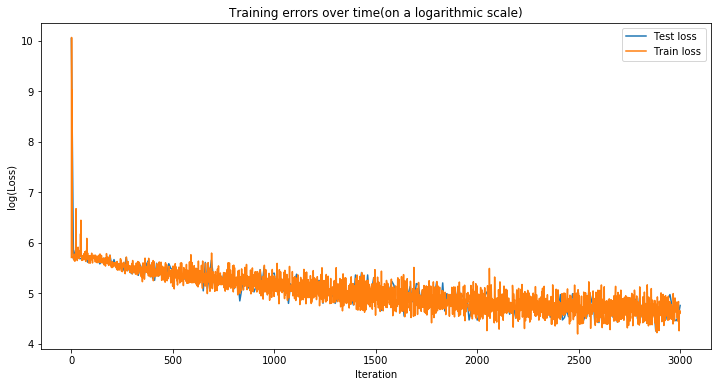

In [14]:
#Визуализация процесса обучения
plt.figure(figsize = (12,6))
plt.plot(
    np.array(range (0,len(test_losses))) / float(len(test_losses) - 1) * (len(train_losses) - 1),
    np.log(test_losses),
    label = "Test loss"
)

plt.plot(
    np.log(train_losses),
    label = "Train loss"
)

plt.title("Training errors over time(on a logarithmic scale)")
plt.xlabel('Iteration')
plt.ylabel('log(Loss)')
plt.legend(loc = 'best')
plt.show()

Let's visualize1 predictions with our signals:


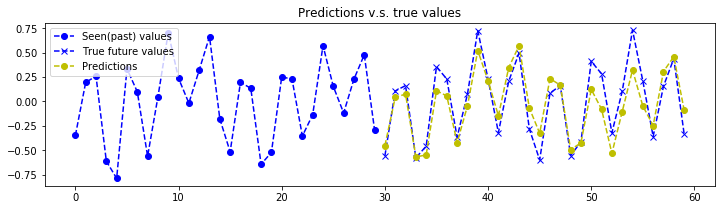

In [15]:
nb_predictions = 1
print ("Let's visualize{} predictions with our signals:".format(nb_predictions))

X,Y = generate_x_y_data_v3(isTrain = False,batch_size = nb_predictions)
feed_dict = {enc_inp[t]:X[t] for t in range (seq_length)}
outputs = np.array(sess.run([reshaped_outputs],feed_dict)[0])

for j in range(nb_predictions):
    plt.figure(figsize = (12,3))
    
    for k in range(output_dim):
        past = X [:,j,k]
        expected = Y [:,j,k]
        pred = outputs [:,j,k]
        
    label1 = "Seen(past) values" if k == 0 else "_nolegend_"
    label2 = "True future values" if k == 0 else "_nolegend_"
    label3 = "Predictions" if k == 0 else "_nolegend_"
    plt.plot(range(len(past)),past,"o--b",label = label1)
    plt.plot(range(len(past),len ( expected )+ len(past)),expected,"x--b",label = label2)
    plt.plot(range(len(past),len ( pred )+ len(past)),pred,"o--y",label = label3)
    
    plt.legend(loc = 'best')
    plt.title("Predictions v.s. true values")
    plt.show()
    
